# Thematic differences (Ukraine)

DHH23 Parliament group

Author: Pontus H.

In [88]:
# Set the theme here
THEME = 'gender_UA'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'

In [89]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

In [90]:
# Optional stopwords
with open('../data/stopwords-ua.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [91]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = 10 # Lowered to 10 from 50
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  # nr_topics=10,
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [92]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,ParlaMint-UA_2017-11-07-m0.u41,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-11-07,Unicameralism,8,7,NaN,2017-11-07,NaN,Reference,...,фБПП,Фракція партії «Блок Петра Порошенка»,Coalition,"Миколайович Черненко, Олександр",M,1976,"Доброго дня, шановні колеги! Хочу представити ...","Цей проект не новий, він розроблений на основ...",0.357422,5588
1,ParlaMint-UA_2017-12-07-m0.u6,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-12-07,Unicameralism,8,7,NaN,2017-12-07,NaN,Reference,...,NaN,NaN,NaN,"Володимирівна Геращенко, Ірина",F,1971,"Дякую. Шановні колеги! Я би дуже хотіла, щоб з...","Шановні колеги! Я би дуже хотіла, щоб зараз а...",0.580566,1556
2,ParlaMint-UA_2017-12-07-m0.u8,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-12-07,Unicameralism,8,7,NaN,2017-12-07,NaN,Reference,...,NaN,NaN,NaN,"Володимирівна Геращенко, Ірина",F,1971,"Я по всім поправкам пройдуся. Але почитайте, т...","Але почитайте, той самийМарк Цукерберг, він з...",-0.753906,2240
3,ParlaMint-UA_2017-12-07-m0.u16,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-12-07,Unicameralism,8,7,NaN,2017-12-07,NaN,Reference,...,фНФ,"Фракція Політичної партії ""Народний фронт""",Coalition,"Романович Величкович, Микола",M,1972,Шановний Андрію Володимировичу! Шановні колеги...,"Проте ми вважаємо, що держава має зупинити до...",-0.543945,654
4,ParlaMint-UA_2017-12-07-m0.u18,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-12-07,Unicameralism,8,7,NaN,2017-12-07,NaN,Reference,...,фБПП,Фракція партії «Блок Петра Порошенка»,Coalition,"Миколаївна Суслова, Ірина",F,1988,"Шановні колеги, у 2011 році Україна підписала ...","Це означає, що на міжнародному рівні ми взяли...",0.481934,1070


In [93]:
df['Speaker_party'].value_counts()

фБПП        19
фНФ         13
фВОБ        12
фСН         10
фОПЗЖ        9
фЄС          8
фОпоблок     4
фУДАР        4
фСвобода     2
гПВ          2
фПГ          2
гДовіра      2
фЛяшко       2
фПР          1
гЕР          1
гСЄУ         1
фОС          1
Name: Speaker_party, dtype: int64

In [94]:
# Reference running time for this cell: 0min 30s
topics, probs = topic_model.fit_transform(df['speech'])


In [95]:
pd.Series(topics).value_counts()

 0    39
 1    32
 2    30
 3    18
-1     3
dtype: int64

In [96]:
# Reduce outliers
# threshold reduced to 0.05 from 0.1
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=0.05)

In [97]:
pd.Series(new_topics).value_counts()

0    39
1    35
2    30
3    18
dtype: int64

In [98]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [99]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [100]:
# Number of topics
print(f"Number of topics before: {len(pd.Series(topics).unique())}")
print(f"Number of topics before: {len(pd.Series(new_topics).unique())}")

Number of topics before: 5
Number of topics before: 4


In [101]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

 0    39
 1    32
 3    30
 2    18
-1     3
dtype: int64

In [102]:
topic_model.visualize_topics()

Topics over time

In [103]:
# Reference running time for this cell: 2min 30s
topics_over_time = topic_model.topics_over_time(df['speech'], df['Date'].to_list(), nr_bins=20)

In [104]:
# Save the topics_over_time dataframe to a feather file
#topics_over_time.to_feather("../data/topics_over_time.feather")

In [105]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
#topic_model.visualize_topics_over_time(topics_over_time, topics=[0,18])


What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [106]:
# Brexit
topics_over_time[topics_over_time['Topic'] == 0]

,Topic,Words,Frequency,Timestamp,Name
0,0,"євросоюз, мітинги, фашизму, спільні, привиди",2,2012-12-09 12:18:43.200,0_україни_питання_виборців_місцевих
2,0,"делегувати, сміттєвих, репутацію, імені, працю...",1,2013-06-05 08:24:00.000,0_україни_питання_виборців_місцевих
4,0,"свобода, приємно, кон, підписатися, мільйон",1,2014-05-20 01:12:00.000,0_україни_питання_виборців_місцевих
5,0,"місцевих, реєстрації, комісій, організацій, це...",2,2015-05-03 18:00:00.000,0_україни_питання_виборців_місцевих
10,0,"змін, україни, закону, волі, язнення",3,2015-10-25 02:24:00.000,0_україни_питання_виборців_місцевих
13,0,"інклюзивне, ключових, компетентностей, лілії, ...",1,2016-04-16 10:48:00.000,0_україни_питання_виборців_місцевих
14,0,"ідентифікує, конвенції, ратифікацію, поговорим...",1,2016-10-07 19:12:00.000,0_україни_питання_виборців_місцевих
19,0,"система, голосів, виборців, принципі, партією",2,2017-09-21 12:00:00.000,0_україни_питання_виборців_місцевих
23,0,"міністерство, скажу, віку, тиждень, тестування",8,2018-03-14 20:24:00.000,0_україни_питання_виборців_місцевих
27,0,"україни, делегації, поправки, вперше, центральної",3,2018-09-05 04:48:00.000,0_україни_питання_виборців_місцевих


In [107]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

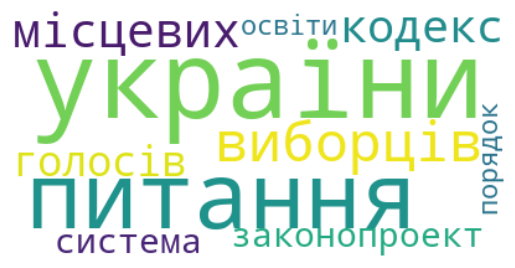

In [108]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [109]:
topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

ValueError: Make sure to set `n_clusters` lower than the total number of unique topics.

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [110]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
get_keywords(0)

['україни',
 'питання',
 'виборців',
 'місцевих',
 'кодекс',
 'голосів',
 'законопроект',
 'система',
 'освіти',
 'порядок']

In [111]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'фБПП.фЄС.фУДАР' if it contains 'фБПП', 'фЄС' or 'фУДАР'
speech_topic_party.loc[speech_topic_party['party'].str.contains('фБПП|фЄС|фУДАР'), 'party'] = 'фБПП.фЄС.фУДАР'
# Set the party name to 'фОПЗЖ.фОпоблок.фПР' if it contains 'фОПЗЖ', 'фОпоблок' or 'фПР'
speech_topic_party.loc[speech_topic_party['party'].str.contains('фОПЗЖ|фОпоблок|фПР'), 'party'] = 'фОПЗЖ.фОпоблок.фПР'
# Set the party name to 'OTHER' if the party name does not contain 'SDS' or 'SD'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('фБПП.фЄС.фУДАР|фОПЗЖ.фОпоблок.фПР'), 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
topic,,,
0,19.0,9.0,3.0
1,8.0,9.0,8.0
2,12.0,9.0,3.0
3,9.0,4.0,0.0


In [112]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
topic,,,
0,39.6,29.0,21.4
1,16.7,29.0,57.1
2,25.0,29.0,21.4
3,18.8,12.9,0.0


In [113]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР,keywords
topic,,,,
0,39.6,29.0,21.4,"[україни, питання, виборців, місцевих, кодекс,..."
1,16.7,29.0,57.1,"[жінок, хочу, законопроект, чоловіків, україни..."
2,25.0,29.0,21.4,"[насильство, дітей, стенограму, поправки, стер..."
3,18.8,12.9,0.0,"[жінки, парламенті, життя, жаль, лікарів, наси..."


In [114]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
0,0,61.3,29.0,9.7
1,1,32.0,36.0,32.0
2,2,50.0,37.5,12.5
3,3,69.2,30.8,0.0


Calculate mean sentiment for each topic per party

In [115]:
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'фБПП.фЄС.фУДАР' if it contains 'фБПП', 'фЄС' or 'фУДАР'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('фБПП|фЄС|фУДАР'), 'party'] = 'фБПП.фЄС.фУДАР'
# Set the party name to 'фОПЗЖ.фОпоблок.фПР' if it contains 'фОПЗЖ', 'фОпоблок' or 'фПР'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('фОПЗЖ|фОпоблок|фПР'), 'party'] = 'фОПЗЖ.фОпоблок.фПР'
# Set the party name to 'OTHER' if the party name does not contain 'SDS' or 'SD'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('фБПП.фЄС.фУДАР|фОПЗЖ.фОпоблок.фПР'), 'party'] = 'OTHER'
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
topic,,,
0,-0.29,0.05,-0.48
1,-0.31,0.02,-0.14
2,-0.33,-0.54,-0.35
3,-0.02,0.22,0.00
